# *Purpose*

**Radar plots** (also known as polar or spider plots) are extremely versatile. In the paper [*The heartbeat of the city*], authors show daily cyclic patterns in crime and crashes in Mexico City. One of the plots they present is a very informative **radar plot** showing differences in crime and crash rates **hourly** and throughout the **days of the week**, in a way that is *visually appealing* and *easy to understand*.

This jupyter notebook is a tutorial on how to do this type of radar plot in python. I used 2021 open data from New York City, [*NYC crime data*].

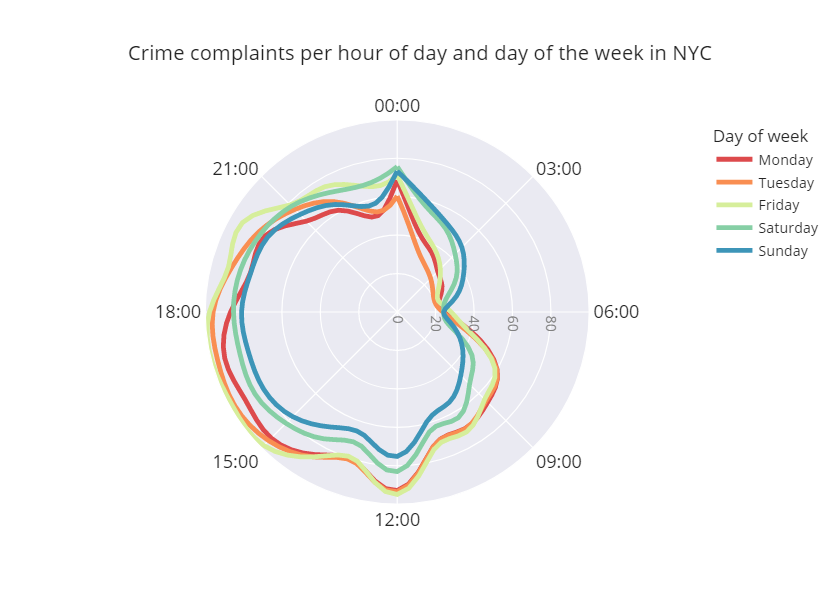

The plot shows a clock but, instead of 12 hours, 24 hours are displayed. Different colored curves show different days of the week. I'm not showing all days of the week to make the plot easier to read, but the remaining days can be easily be added. Some conclusions we can reach when looking at this plot:
* crime occurrences follow a slightly different pattern for week days vs. weekends;
* highest crime rates are found between 3pm and 6pm;
* there's more crime between midnight and 6am on weekends than during weekdays;
* crime peaks at different times of the day: at midnight, in the morning between 7 and 8pm (for week days), at midday and in the afternnoon (between 3 and 6pm on weekdays);
* on average there's more crime on saturday than on sunday, except between midnight and 6am.

[*The heartbeat of the city*]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0246714
[*NYC crime data*]: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243


## package imports

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime
from scipy.interpolate import interp1d

## Crime data

NYC crime [*data*]:

[*data*]: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243

In [2]:
NYC_crime = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv')

In [3]:
NYC_crime.head(2)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,903695881,69,NaN,12/17/2021,22:13:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK,M,1011203,174515,40.645647,-73.902876,"(40.64564719600002, -73.90287588699994)",POINT (-73.90287588699994 40.64564719600002)
1,400462399,113,NaN,12/17/2021,06:21:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK,F,1043252,187998,40.682499,-73.787269,"(40.682499421000045, -73.78726915499993)",POINT (-73.78726915499993 40.682499421000045)


Total of ~450K crime complaints:

In [4]:
len(NYC_crime), NYC_crime['CMPLNT_NUM'].nunique()

(449506, 449506)

I only keep keep 3 variables for the purpose of this work:
* **CMPLNT_NUM**: Randomly generated persistent ID for each complaint;
* **CMPLNT_FR_DT**: Exact date of occurrence for the reported event;
* **CMPLNT_FR_TM**: Exact time of occurrence for the reported event.

In [5]:
NYC_crime = NYC_crime[['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM']]

## First look at data, data cleaning & creating new variables

Date of occurrence (*month/day/year*):

In [6]:
NYC_crime['CMPLNT_FR_DT'].nunique()

1979

In [7]:
NYC_crime['CMPLNT_FR_DT'].head()

0    12/17/2021
1    12/17/2021
2    12/13/2021
3    12/07/2021
4    12/06/2021
Name: CMPLNT_FR_DT, dtype: object

Extracting day, month and year from date of occcurrence:

In [8]:
NYC_crime['month'] = NYC_crime['CMPLNT_FR_DT'].str[:2].astype(int)
NYC_crime['day'] = NYC_crime['CMPLNT_FR_DT'].str[3:5].astype(int)
NYC_crime['year'] = NYC_crime['CMPLNT_FR_DT'].str[6:].astype(int)

Month values:

In [9]:
NYC_crime['month'].nunique()

12

In [10]:
NYC_crime['month'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

Day values:

In [11]:
NYC_crime['day'].nunique(), NYC_crime['day'].min(), NYC_crime['day'].max()

(31, 1, 31)

Year values:

*There are some weird year values, 1021 and 1019. These are typos and should probably be, 2021 and 2019 respectively, but I decided to remove the instances (they are only 8 anyway...).*

In [12]:
NYC_crime['year'].nunique(), NYC_crime['year'].min(), NYC_crime['year'].max()

(60, 1019, 2021)

In [13]:
NYC_crime[NYC_crime['year']<1900]['year'].unique()

array([1021, 1019])

In [14]:
len(NYC_crime[NYC_crime['year'].isin([1021, 1019])])

8

In [15]:
NYC_crime = NYC_crime[~NYC_crime['year'].isin([1021, 1019])]

In [16]:
NYC_crime['year'].nunique(), NYC_crime['year'].min(), NYC_crime['year'].max()

(58, 1920, 2021)

Number of complaints per year:

*Here I'm grouping complaints per year and sorting the dataframe according to number of complaints per year from highest to lowest and looking at the top 15 years in terms of number of complaints. As one can see, the order of magnitude differs quite a lot from year to year.*

In [17]:
NYC_crime.groupby('year').nunique()[['CMPLNT_NUM']].sort_values('CMPLNT_NUM', ascending=False).head(15)

,CMPLNT_NUM
year,
2021,439625
2020,7329
2019,898
2018,335
2017,244
2016,175
2015,116
2014,111
2012,99


Keep only data from 2021:

*From now on we look only at 2021 data.*

In [18]:
NYC_crime = NYC_crime[NYC_crime['year']==2021]

Creating date and time related variables:

* **date**: date of occurrence in datetime format
* **weekday**: number representing the day of the week 0 (Monday) - 6 (Sunday)
* **day_name**: day of the week (Monday, ...., Sunday)
* **hour**: hour of occurrence

In [19]:
NYC_crime['date'] = pd.to_datetime(NYC_crime['CMPLNT_FR_DT'])

NYC_crime['weekday'] = NYC_crime['date'].dt.weekday

NYC_crime['day_name'] = NYC_crime['date'].dt.day_name()

NYC_crime['hour'] = NYC_crime['CMPLNT_FR_TM'].str[:2]
NYC_crime['hour'] = NYC_crime['hour'].astype(int)

In [20]:
NYC_crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,month,day,year,date,weekday,day_name,hour
0,903695881,12/17/2021,22:13:00,12,17,2021,2021-12-17,4,Friday,22
1,400462399,12/17/2021,06:21:00,12,17,2021,2021-12-17,4,Friday,6
2,587910690,12/13/2021,20:05:00,12,13,2021,2021-12-13,0,Monday,20
3,186105368,12/07/2021,22:49:00,12,7,2021,2021-12-07,1,Tuesday,22
4,185325394,12/06/2021,17:25:00,12,6,2021,2021-12-06,0,Monday,17


## Getting data ready for radar plot

Grouping complaints per day of the week and hour of day:

*Although we have info up to the minute I decided to aggregate data hourly, as I'm not sure the info can be "trusted" up to the minute (E.g. the person making the complaint might not be sure of the exact time the crime took place, etc.)*

In [21]:
crime_PerDayWeekHour = NYC_crime.groupby(['weekday', 'day_name', 'hour'])[['CMPLNT_NUM']].nunique()

In [22]:
crime_PerDayWeekHour.head()

CMPLNT_NUM
weekday day_name hour            
0       Monday   0           2799
                 1           1758
                 2           1460
                 3           1216
                 4           1098

In [23]:
crime_PerDayWeekHour.columns = ['#complaints']
crime_PerDayWeekHour.reset_index(inplace=True)

In [24]:
crime_PerDayWeekHour.head()

,weekday,day_name,hour,#complaints
0,0,Monday,0,2799
1,0,Monday,1,1758
2,0,Monday,2,1460
3,0,Monday,3,1216
4,0,Monday,4,1098


Creating a string with the hour of the day:

*Examples:*

* *0 -> 00:00*
* *15 -> 15:00*

In [25]:
def str_hour(hour):
    if hour<12:
        return '0'+str(hour)+':00'
    else:
        return str(hour)+':00'

In [26]:
crime_PerDayWeekHour['str_hour'] = crime_PerDayWeekHour['hour'].apply(str_hour)

In [27]:
crime_PerDayWeekHour.head()

,weekday,day_name,hour,#complaints,str_hour
0,0,Monday,0,2799,00:00
1,0,Monday,1,1758,01:00
2,0,Monday,2,1460,02:00
3,0,Monday,3,1216,03:00
4,0,Monday,4,1098,04:00


Calculating a **crime complaints metric** which is as a percentage of the maximum number of complaints for a pair *(day of the week, hour of day)*:

*The maximum number of occurences of a (day of the week, hour of day) pair in 2021 is on Wednesday at 4pm.*

In [28]:
crime_PerDayWeekHour['%'] = crime_PerDayWeekHour['#complaints']/max(crime_PerDayWeekHour['#complaints'])*100

In [29]:
crime_PerDayWeekHour[crime_PerDayWeekHour['%']==100]

,weekday,day_name,hour,#complaints,str_hour,%
64,2,Wednesday,16,4077,16:00,100.0


## RADAR PLOT

### 1. First radar plot:

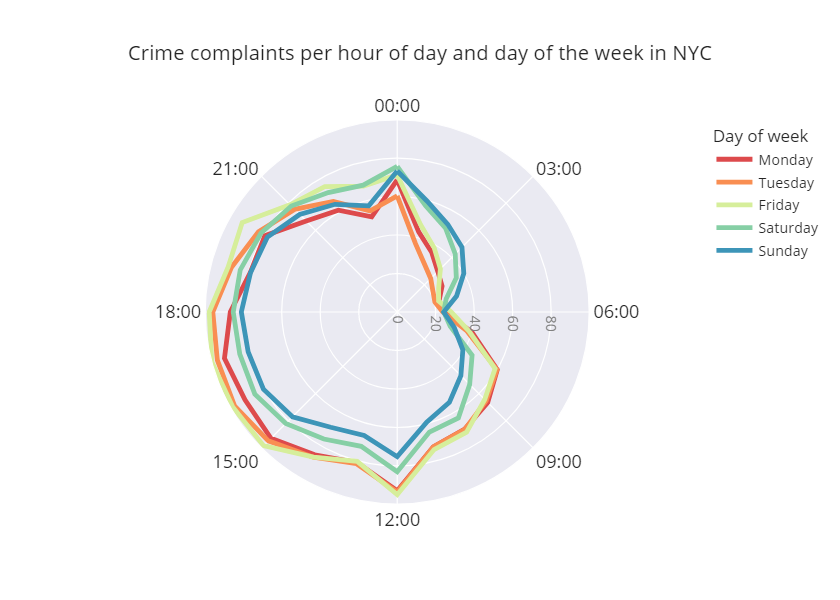

*In the first radar plot, I plot hourly values of % of occurences per day of the week and join these values with straight lines. Hence, the result is not smooth.*

List of colors for each day of the week:

In [30]:
colors = sns.color_palette("Spectral",n_colors =7).as_hex()

Days of the week to plot:

*For the purpose of this tutorial I'm plotting Monday, Tuesday, Friday, Saturday and Sunday.*

In [31]:
days = [0,1,4,5,6]

Data to plot:

In [32]:
df = crime_PerDayWeekHour[crime_PerDayWeekHour['weekday'].isin(days)]

Figure:

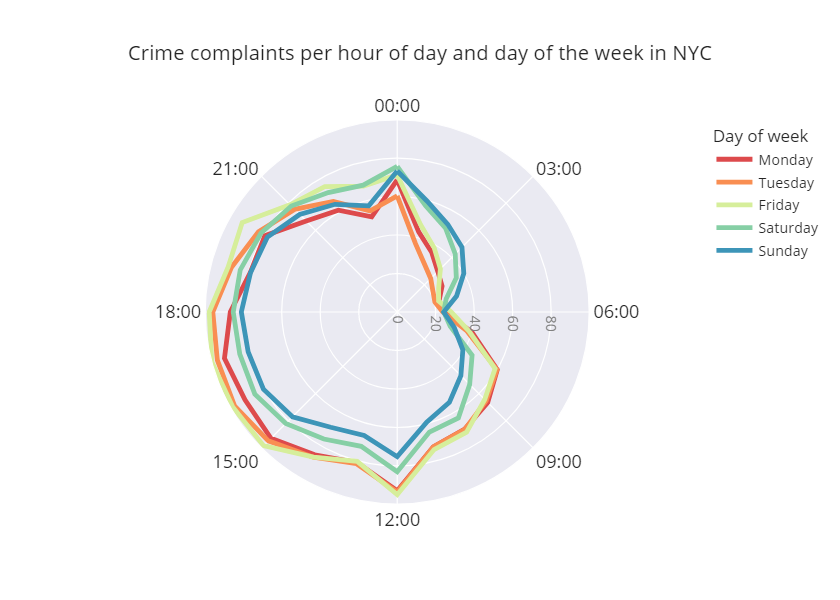

In [33]:
fig = px.line_polar(data_frame = df,
                    r = "%",
                    theta = "str_hour",
                    color = "day_name",
                    labels = {'day_name': 'Day of week', 'str_hour': 'Hour of day'},
                    line_close=True,
                    color_discrete_sequence=[colors[j] for j in days],
                    template="seaborn",
                    title = 'Crime complaints per hour of day and day of the week in NYC')

fig.update_layout(
    polar = dict(
        angularaxis = dict(showticklabels=True, ticks='', nticks = 8, tickfont_size = 15), 
        radialaxis = dict(ticks='',tickangle=90, angle = 0, linewidth=0, color='grey', nticks = 5),
    )
)

fig.update_traces(line=dict(width=4))


fig.show("png", scale=1.2)
# for interactive plot:
#fig.show()

#figure as png
fig.write_image("./plots/crime_radar_plot.png", scale=1.2)

### 2. Smoother radar plot

In order to have smooth curves one needs to do [**interpolation**]. Interpolation works by fitting a function to a discrete set of data points. After that one can calculate $y = f(x)$ for any $x$ in within the considered range of $x$ values. 

In the context o this problem, we have hourly % of complaints and we want to estimate the % of complaints for any point in time in the range [0, 24[.

I fitted a cubic interpolation function (*other orders can be considered*) for each day of the week. Then I used these functions to estimate the % of crime complaints at every 15 minutes (*any time range can be chosen*).

Let $f_i(x)$ be the interpolation function for the $i^{th}$ day of the week, with $x\in[0,24[$ and $i\in \{0,1, ..., 6\} $. Then, $f_2(1.5)$ will be the estimated value of % of complaints on Wednesday at 01:30am.

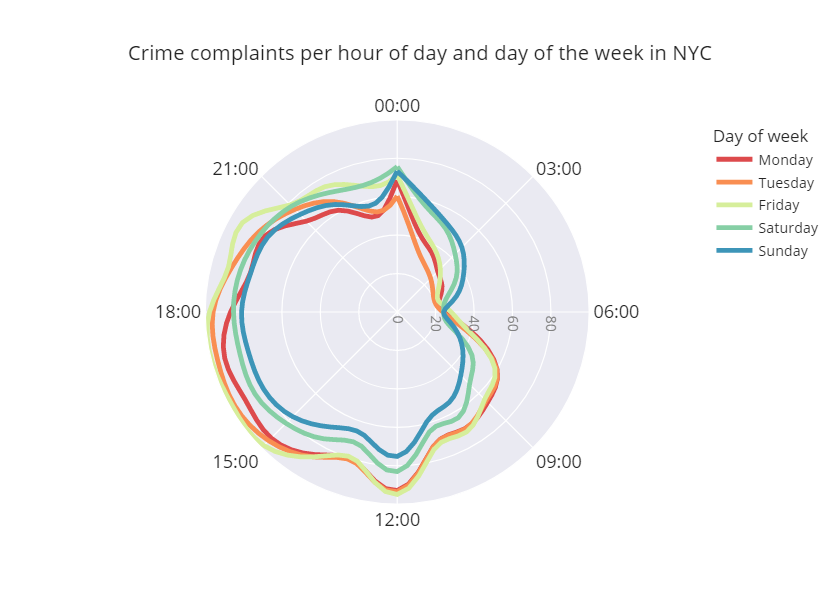

[**interpolation**]: https://en.wikipedia.org/wiki/Interpolation

The first step is to fit interpolation functions for each day of the week:

* **y** is a list with the values of % of complaints ordered by hour of the day. As we need to estimate values between hour 23 and midnight, we add the % of complaints of hour 0 at the end of the list. 
* **x** is a list with the order hours of the day. We add hour 24 at the end of the list to be able to calculate estimates between hour 23 and midnight.

In [34]:
interpolation_functions = []
for i in range(7):
    y = list(crime_PerDayWeekHour[crime_PerDayWeekHour['weekday']==i]['%'])
    y = y + [y[0]]
    x = list(crime_PerDayWeekHour[crime_PerDayWeekHour['weekday']==i]['hour'])
    x = x + [24]
    f = interp1d(x,y, kind='cubic')
    interpolation_functions.append(f)

We create a dataframe called **iterpolation_data** similar to dataframe **crime_PerDayWeekHour**. It has info on the % of complaints for each day of the week and at each 15 minutes (if we divide an hour in 15 minute intervals we get 4 intervals so we set **points_per_hour** = 4).

In [35]:
points_per_hour = 4

iterpolation_data = pd.DataFrame(columns = ['weekday', 'hour', '%'])

for wd in range(7):
    auxiliar_df = pd.DataFrame(columns = ['weekday', 'hour', '%'])
    auxiliar_df['hour'] = [h/points_per_hour for h in range(0, 24*points_per_hour, 1)]
    auxiliar_df['weekday'] = [wd for i in range(len(auxiliar_df))]
    auxiliar_df.set_index('hour', inplace=True)
    for h in range(0, 24*points_per_hour, 1):
        auxiliar_df['%'].loc[h/points_per_hour] = interpolation_functions[wd](h/points_per_hour)
    auxiliar_df.reset_index(inplace=True)
    iterpolation_data = pd.concat([iterpolation_data, auxiliar_df])

In [36]:
iterpolation_data.head()

,weekday,hour,%
0,0,0.00,68.65342163355407
1,0,0.25,59.32715982201251
2,0,0.50,52.19794473368934
3,0,0.75,46.91309797020657
4,0,1.00,43.119941133186174


Transforming variable hour into a readable time:

.25 -> :15  (1/4=.25th part of the hour, minute 15)

.5 -> :30 (2/4th=.50 part of the hour, minute 30)

.75 -> :45 (3/4th=0.75th part of the hour, minute 45)

In [37]:
def readableTime(hour):
    """
    E.g.: hour = 2.25
    Then: h = 2 and m=0.25
          m*60=0.25*60=15
    Returned value: '2:15'
    """
    
    #gives us the hour
    h = str(hour).split('.')[0] 
    
    #gives us n-th part of the hour we are considering
    m = str(hour).split('.')[1] 
    m = float('0.'+m)
    return h+':'+str(int(m*60)) #gives us the hours and minutes

In [38]:
iterpolation_data['readable_time'] = iterpolation_data['hour'].apply(readableTime)

In [39]:
def addZeroLeft(hour):
    #'3:45'->'03:45'
    if int(hour.split(':')[0])<10:
        return '0'+hour
    else: #'13:45'->'13:45'
        return hour

In [40]:
iterpolation_data['readable_time'] = iterpolation_data['readable_time'].apply(addZeroLeft)

In [41]:
def addZeroRight(hour):
    #'03:0'->'03:00'
    if int(hour.split(':')[1])==0:
        return hour+'0'
    else: #'03:45'->'03:45'
        return hour

In [42]:
iterpolation_data['readable_time'] = iterpolation_data['readable_time'].apply(addZeroRight)

In [43]:
iterpolation_data.head()

,weekday,hour,%,readable_time
0,0,0.00,68.65342163355407,00:00
1,0,0.25,59.32715982201251,00:15
2,0,0.50,52.19794473368934,00:30
3,0,0.75,46.91309797020657,00:45
4,0,1.00,43.119941133186174,01:00


Adding days of the week information:

In [44]:
dayname_info = crime_PerDayWeekHour[['weekday', 'day_name']]
dayname_info.drop_duplicates(['weekday', 'day_name'], inplace=True)
dayname_info.set_index('weekday', inplace=True)
iterpolation_data.set_index('weekday', inplace=True)
iterpolation_data['day_name'] = dayname_info['day_name']

dayname_info.reset_index(inplace=True)
iterpolation_data.reset_index(inplace=True)

In [45]:
iterpolation_data.head()

,weekday,hour,%,readable_time,day_name
0,0,0.00,68.65342163355407,00:00,Monday
1,0,0.25,59.32715982201251,00:15,Monday
2,0,0.50,52.19794473368934,00:30,Monday
3,0,0.75,46.91309797020657,00:45,Monday
4,0,1.00,43.119941133186174,01:00,Monday


Days of the week to plot:

*For the purpose of this tutorial I'm plotting Monday, Tuesday, Friday, Saturday and Sunday.*

In [46]:
days = [0,1,4,5,6]

Data to plot:

In [47]:
df = iterpolation_data[iterpolation_data['weekday'].isin(days)]

Figure:

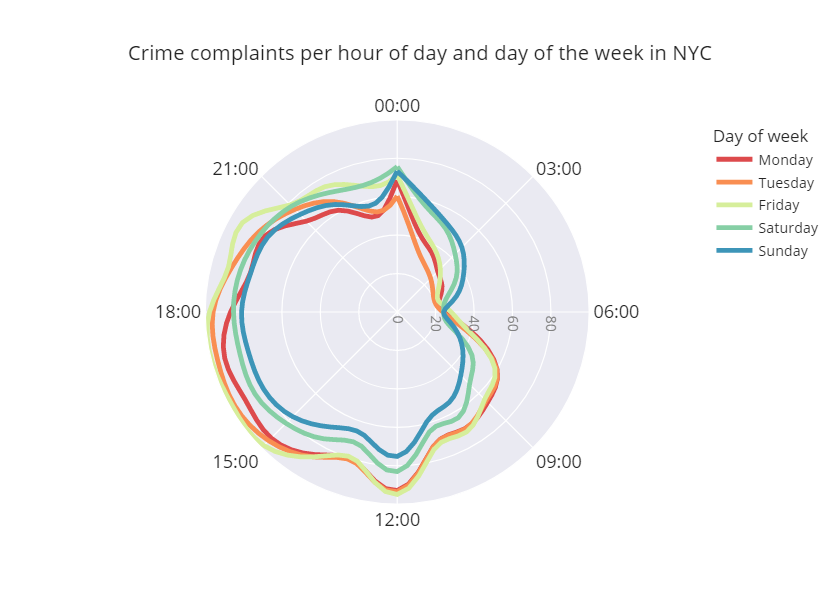

In [48]:
fig = px.line_polar(data_frame = df,
                    r = "%",
                    theta = "readable_time",
                    color = "day_name",
                    labels = {'day_name': 'Day of week', 'readable_time': 'Time'},
                    line_close=True,
                    color_discrete_sequence=[colors[j] for j in days], #colors list as defined for previous plot
                    template="seaborn",
                    title = 'Crime complaints per hour of day and day of the week in NYC')

fig.update_layout(
    polar = dict(
        angularaxis = dict(showticklabels=True, ticks='', nticks = 8, tickfont_size = 15), 
        radialaxis = dict(ticks='',tickangle=90, angle = 0, linewidth=0, color='grey', nticks = 5),
    )
)

fig.update_traces(line=dict(width=4))


fig.show("png", scale=1.2)
# for interactive plot:
#fig.show()

#figure as png
fig.write_image("./plots/crime_interpolated_radar_plot.png", scale=1.2)

## Useful links

https://plotly.com/python/polar-chart/

https://plotly.com/python-api-reference/generated/plotly.express.line_polar.html

https://plotly.com/python/templates/

https://plotly.com/python/reference/layout/polar/


